# Final Project - Rachel Livingston
## A CSAT Classification Problem

### Project Summary:
This project is a classification problem with customer support tickets to see if I can predict if a support ticket will be rated good (1) or bad (0). The business question is that if we can proactively prediect a bad csat score, we can give those tickets more "love"and try to turn them into a positive rating instead. 

### Project Dataset:
24,552 support tickets with a satisfaction rating from 2019 YTD. The features selected are the features our contact management system allows us to route or flag tickets so we can action on the tickets.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load data
df = pd.read_csv('data/case study combined.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24552 entries, 0 to 24551
Data columns (total 17 columns):
ticket id                24552 non-null int64
customer type            24267 non-null object
hour ticket created      24552 non-null int64
created date             24552 non-null object
solved date              24552 non-null object
agent wait time          24552 non-null float64
assign time              24552 non-null float64
first reply time         24552 non-null float64
first resolution time    24552 non-null float64
full resolution time     24552 non-null float64
private comments         24552 non-null int64
public comments          24552 non-null int64
agent stations           24552 non-null int64
reopens                  24552 non-null int64
replies                  24552 non-null int64
satisfaction             24552 non-null int64
Wrap Up Code             24552 non-null object
dtypes: float64(5), int64(8), object(4)
memory usage: 3.2+ MB


While there are other interesting features I could consider, these are the features within our CRM system (Zendesk) that I can actually build queues around in real-time and route tickets to supervisors, team leads or more experienced agents to solve.

In [4]:
# Explore the data
df.head()

,ticket id,customer type,hour ticket created,created date,solved date,agent wait time,assign time,first reply time,first resolution time,full resolution time,private comments,public comments,agent stations,reopens,replies,satisfaction,Wrap Up Code
0,803178,Couple,17,08/13/2019,09/04/2019,14.0,0.0,28430.0,31536.0,31572.0,4,7,1,1,3,1,Proactive Outreach
1,732468,Guest,16,06/14/2019,06/27/2019,2.0,0.0,18527.0,18527.0,18527.0,10,2,1,0,1,1,Registry
2,705148,Couple,17,05/22/2019,06/04/2019,0.0,0.0,17190.0,14326.0,18738.0,4,6,1,3,2,1,Registry
3,611418,Couple,13,02/15/2019,02/25/2019,0.0,0.0,14523.0,0.0,14523.0,6,2,1,2,1,0,Registry
4,619896,Guest,13,02/26/2019,03/07/2019,0.0,0.0,12933.0,8730.0,13411.0,5,4,1,2,2,0,Registry


In [5]:
df.tail()

,ticket id,customer type,hour ticket created,created date,solved date,agent wait time,assign time,first reply time,first resolution time,full resolution time,private comments,public comments,agent stations,reopens,replies,satisfaction,Wrap Up Code
24547,819639,NaN,7,08/28/2019,08/28/2019,0.0,13.0,0.0,13.0,13.0,0,1,1,0,0,0,Miscellaneous
24548,819703,Guest,9,08/28/2019,08/28/2019,0.0,83.0,0.0,83.0,83.0,0,1,1,0,0,0,Miscellaneous
24549,824950,Couple,16,09/02/2019,09/02/2019,0.0,0.0,0.0,0.0,0.0,1,1,1,0,0,0,Registry
24550,825973,Guest,13,09/03/2019,09/03/2019,0.0,0.0,0.0,0.0,0.0,1,1,1,0,0,0,Registry
24551,826477,Couple,17,09/03/2019,09/03/2019,0.0,0.0,0.0,0.0,0.0,0,1,1,0,0,0,Registry


In [6]:
# Rename one or more columns to remove spaces
df.rename(columns={'ticket id':'ticket_id', 'customer type':'customer_type', 'hour ticket created':'hour_ticket_created'}, inplace = True);

In [7]:
df.rename(columns={'created date':'created_date', 'solved date':'solved_date', 'agent wait time':'agent_wait_time'}, inplace = True);

In [8]:
df.rename(columns={'assign time':'assign_time', 'first reply time':'first_reply_time', 'first resolution time':'first_resolution_time'}, inplace = True);

In [9]:
df.rename(columns={'private comments':'private comments', 'public comments':'public_comments', 'agent stations':'agent_stations'}, inplace = True);

In [10]:
df.rename(columns={'Wrap Up Code':'wrap_up_code','full resolution time':'full_resolution_time', 'private comments':'private_comments'}, inplace = True);

In [11]:
df.columns

Index(['ticket_id', 'customer_type', 'hour_ticket_created', 'created_date',
       'solved_date', 'agent_wait_time', 'assign_time', 'first_reply_time',
       'first_resolution_time', 'full_resolution_time', 'private_comments',
       'public_comments', 'agent_stations', 'reopens', 'replies',
       'satisfaction', 'wrap_up_code'],
      dtype='object')

In [12]:
# Clean up date datatypes
from datetime import datetime
df['created_date'] = pd.to_datetime(df.created_date)

In [13]:
df['solved_date'] = pd.to_datetime(df.solved_date)

ticket_id                  0
customer_type            285
hour_ticket_created        0
created_date               0
solved_date                0
agent_wait_time            0
assign_time                0
first_reply_time           0
first_resolution_time      0
full_resolution_time       0
private_comments           0
public_comments            0
agent_stations             0
reopens                    0
replies                    0
satisfaction               0
wrap_up_code               0
dtype: int64


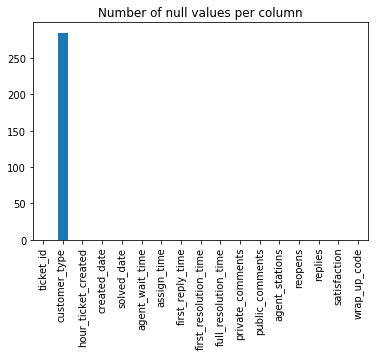

In [14]:
# Count the missing values in each column
print((df.isnull().sum()))

df.isnull().sum().plot(kind='bar');
plt.title('Number of null values per column');

In [15]:
# get rid of N/A values in customer type, it is a tiny number and can be ignored
df.dropna(inplace=True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24267 entries, 0 to 24551
Data columns (total 17 columns):
ticket_id                24267 non-null int64
customer_type            24267 non-null object
hour_ticket_created      24267 non-null int64
created_date             24267 non-null datetime64[ns]
solved_date              24267 non-null datetime64[ns]
agent_wait_time          24267 non-null float64
assign_time              24267 non-null float64
first_reply_time         24267 non-null float64
first_resolution_time    24267 non-null float64
full_resolution_time     24267 non-null float64
private_comments         24267 non-null int64
public_comments          24267 non-null int64
agent_stations           24267 non-null int64
reopens                  24267 non-null int64
replies                  24267 non-null int64
satisfaction             24267 non-null int64
wrap_up_code             24267 non-null object
dtypes: datetime64[ns](2), float64(5), int64(8), object(2)
memory usage: 3.3+ M

In [17]:
df.describe(include='all')

,ticket_id,customer_type,hour_ticket_created,created_date,solved_date,agent_wait_time,assign_time,first_reply_time,first_resolution_time,full_resolution_time,private_comments,public_comments,agent_stations,reopens,replies,satisfaction,wrap_up_code
count,24267.000000,24267,24267.000000,24267,24267,24267.000000,24267.000000,24267.000000,24267.000000,24267.000000,24267.000000,24267.000000,24267.000000,24267.000000,24267.000000,24267.000000,24267
unique,NaN,2,NaN,248,247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
top,NaN,Couple,NaN,2019-06-11 00:00:00,2019-06-13 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Registry
freq,NaN,13060,NaN,186,237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18251
first,NaN,NaN,NaN,2019-01-01 00:00:00,2019-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2019-09-05 00:00:00,2019-09-05 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,704497.731405,NaN,14.243747,NaN,NaN,136.576709,428.262332,543.621296,824.703795,1473.993942,0.634730,3.365888,1.035521,0.669345,1.521902,0.923765,NaN
std,73279.517176,NaN,5.069862,NaN,NaN,653.098835,537.678539,825.976101,1595.970845,2434.881291,1.403864,2.178511,0.211686,0.890781,1.145931,0.265380,NaN
min,579891.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,NaN
25%,640293.000000,NaN,11.000000,NaN,NaN,0.000000,8.000000,23.000000,25.000000,83.000000,0.000000,2.000000,1.000000,0.000000,1.000000,1.000000,NaN


In [18]:
# Convert any non-numeric attributes to numbers with getdummies
df = pd.get_dummies(df, columns=['customer_type', 'wrap_up_code'], drop_first=True)

In [19]:
df.dtypes

ticket_id                                   int64
hour_ticket_created                         int64
created_date                       datetime64[ns]
solved_date                        datetime64[ns]
agent_wait_time                           float64
assign_time                               float64
first_reply_time                          float64
first_resolution_time                     float64
full_resolution_time                      float64
private_comments                            int64
public_comments                             int64
agent_stations                              int64
reopens                                     int64
replies                                     int64
satisfaction                                int64
customer_type_Guest                         uint8
wrap_up_code_Hot Topic                      uint8
wrap_up_code_Invitations                    uint8
wrap_up_code_Legal/Copyright                uint8
wrap_up_code_Miscellaneous                  uint8


In [20]:
#set ticket_id as index
df.set_index('ticket_id', inplace=True)

# EDA

Now the the initial data clean up is done, let's explore the data in more detail. Based on my industry knowledge, my gut feelings is that tickets that take longer to solve are more likely to have poor CSAT ratings.

In [21]:
# Look at correlation... even though this isn't a linear regression, it is classification
corr = df.corr()

In [22]:
corr['satisfaction']

hour_ticket_created               -0.004198
agent_wait_time                   -0.143335
assign_time                       -0.029197
first_reply_time                  -0.054476
first_resolution_time             -0.039766
full_resolution_time              -0.287666
private_comments                  -0.163681
public_comments                   -0.123894
agent_stations                    -0.053026
reopens                           -0.247668
replies                           -0.172029
satisfaction                       1.000000
customer_type_Guest                0.027213
wrap_up_code_Hot Topic             0.012816
wrap_up_code_Invitations          -0.034876
wrap_up_code_Legal/Copyright      -0.039153
wrap_up_code_Miscellaneous        -0.010533
wrap_up_code_Proactive Emails     -0.008033
wrap_up_code_Proactive Outreach    0.007144
wrap_up_code_Real Weddings        -0.016383
wrap_up_code_Registry              0.065943
wrap_up_code_Registry Advisor     -0.004880
wrap_up_code_Tech Issues        

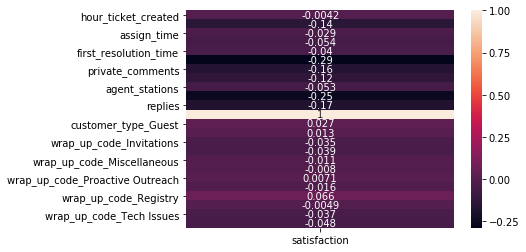

In [23]:
sns.heatmap(corr[['satisfaction']], annot=True)

Granted correlation is for linear regression, it looks like the following metrics have the largest impact on satisfaction

1. agent_wait_time 
2. full_resolution_time
3. private_comments
4. public_comments
5. reopens 
6. replies 

In [24]:
# plot the data to see some initial insights
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['font.size'] = 10

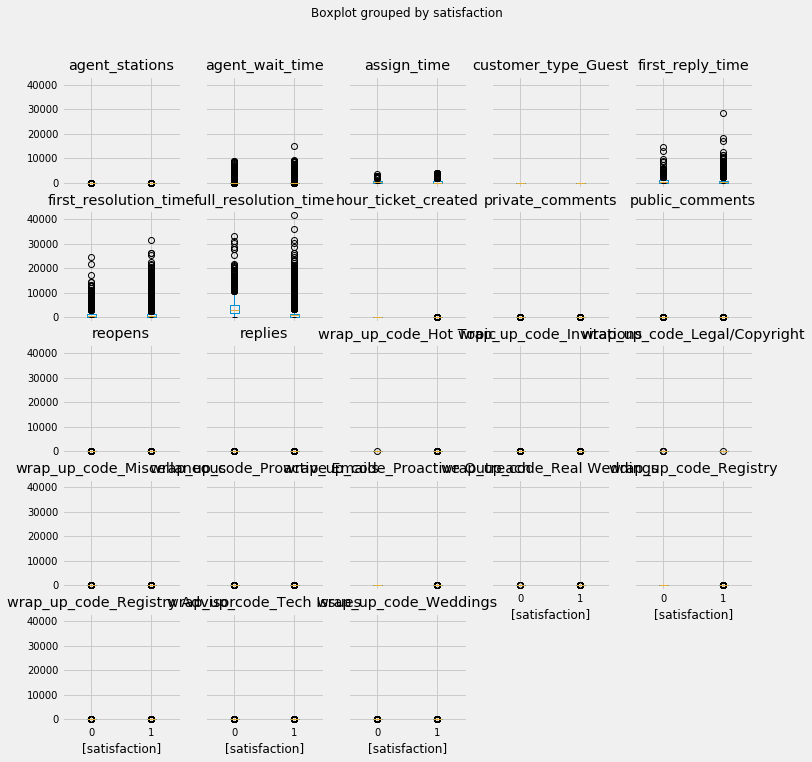

In [25]:
df.boxplot(by='satisfaction');

That initial view of histograms isn't very helpful, so focus on the 6 columns noted above.

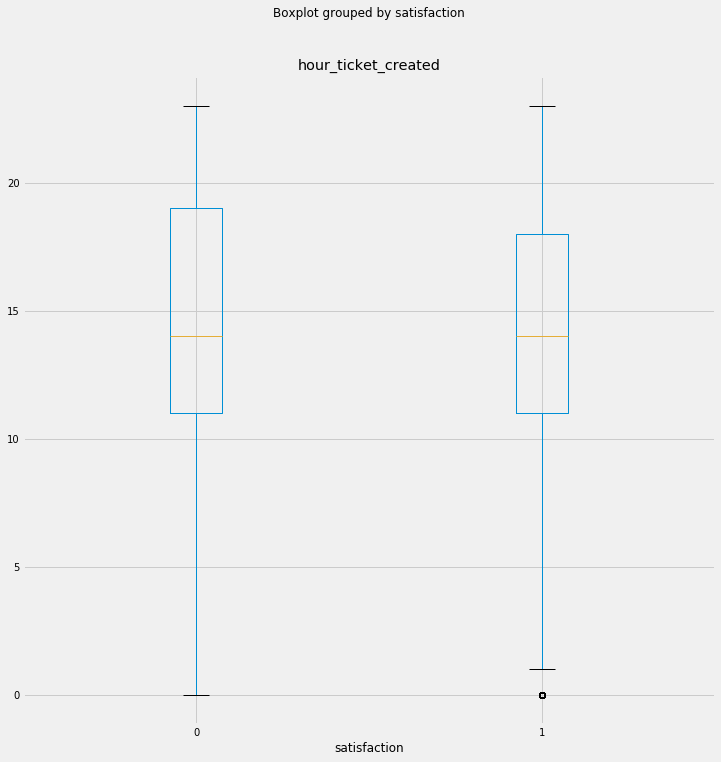

In [26]:
#look at boxplot of hour_ticket_created
df.boxplot(column=['hour_ticket_created'],by='satisfaction')

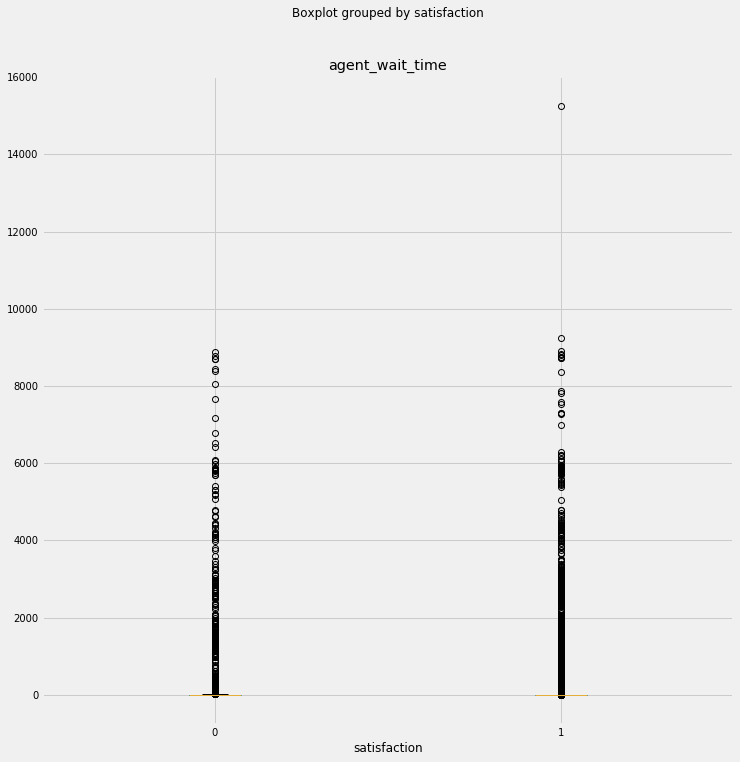

In [27]:
#look at boxplot of agent_wait_time
df.boxplot(column=['agent_wait_time'],by='satisfaction')

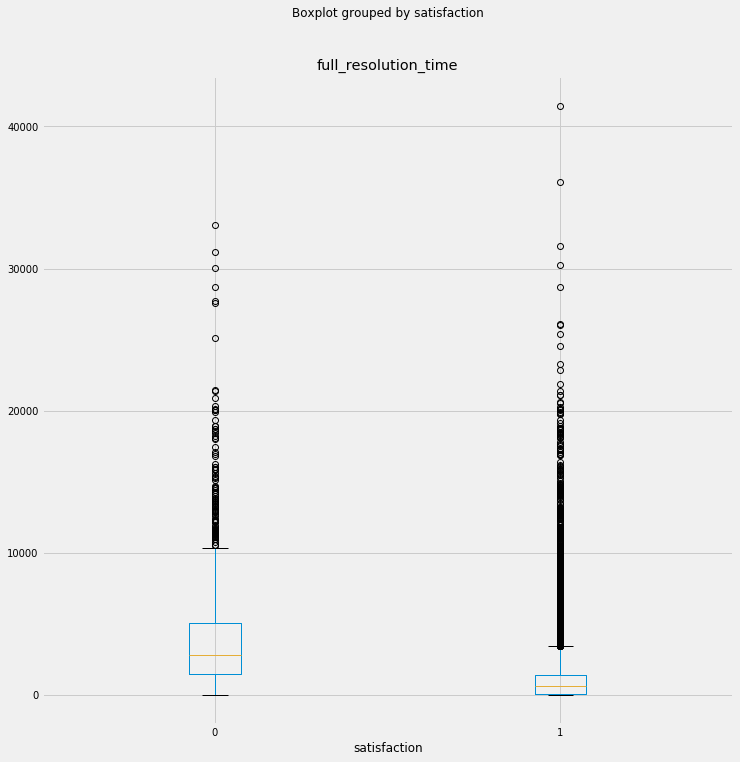

In [28]:
#look at boxplot of full_resolution_time
df.boxplot(column=['full_resolution_time'],by='satisfaction')

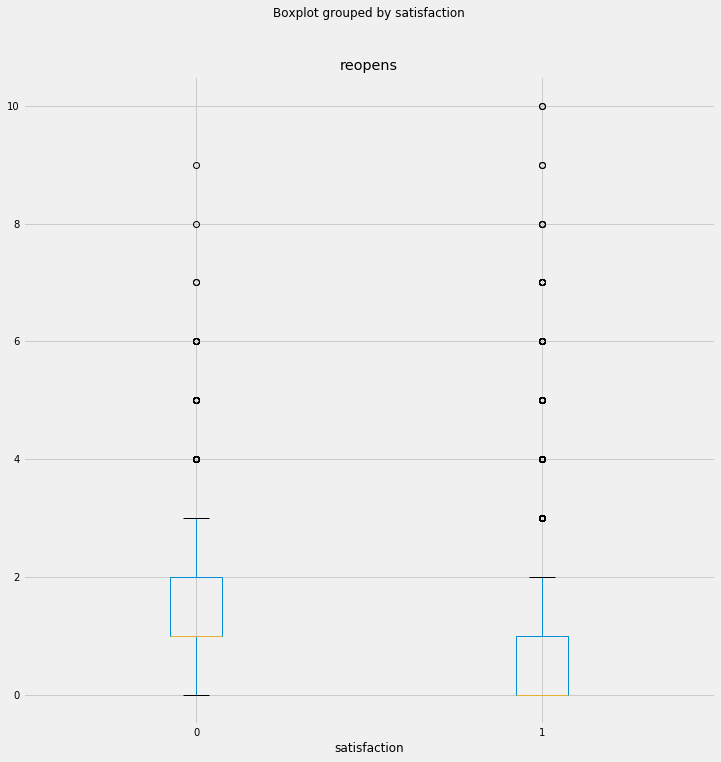

In [29]:
#look at boxplot of reopens
df.boxplot(column=['reopens'],by='satisfaction')

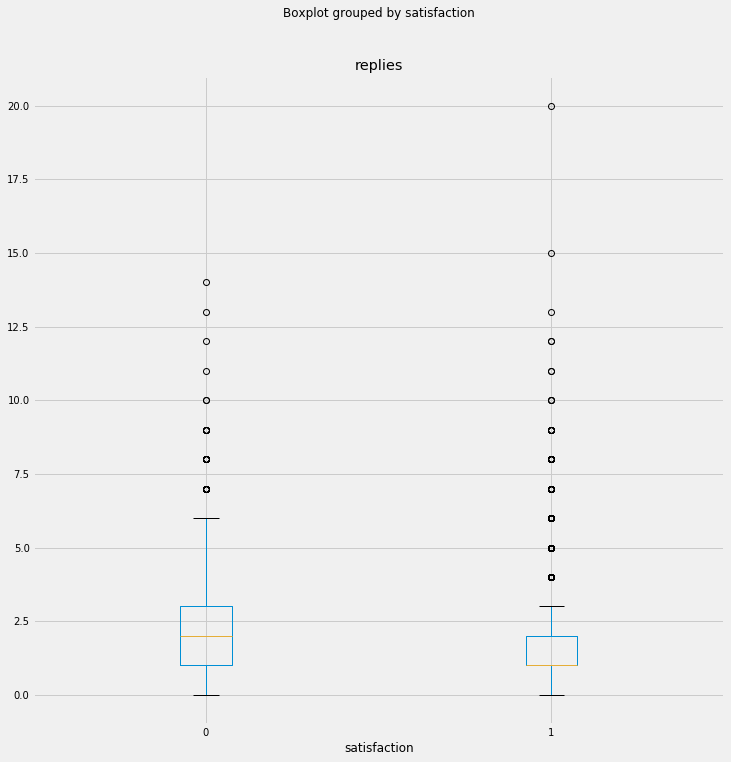

In [30]:
#look at boxplot of replies
df.boxplot(column=['replies'],by='satisfaction')

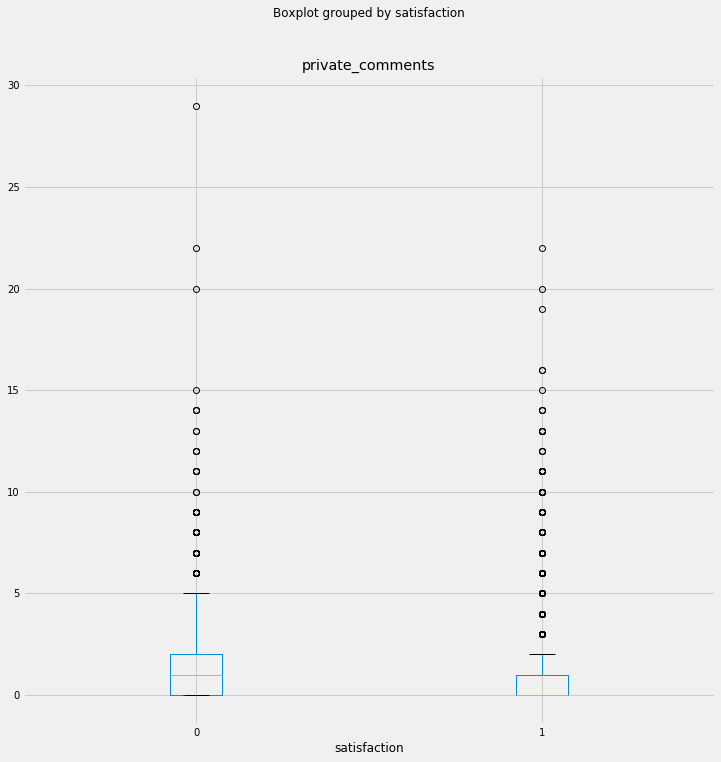

In [31]:
#look at boxplot of private_comments
df.boxplot(column=['private_comments'],by='satisfaction')

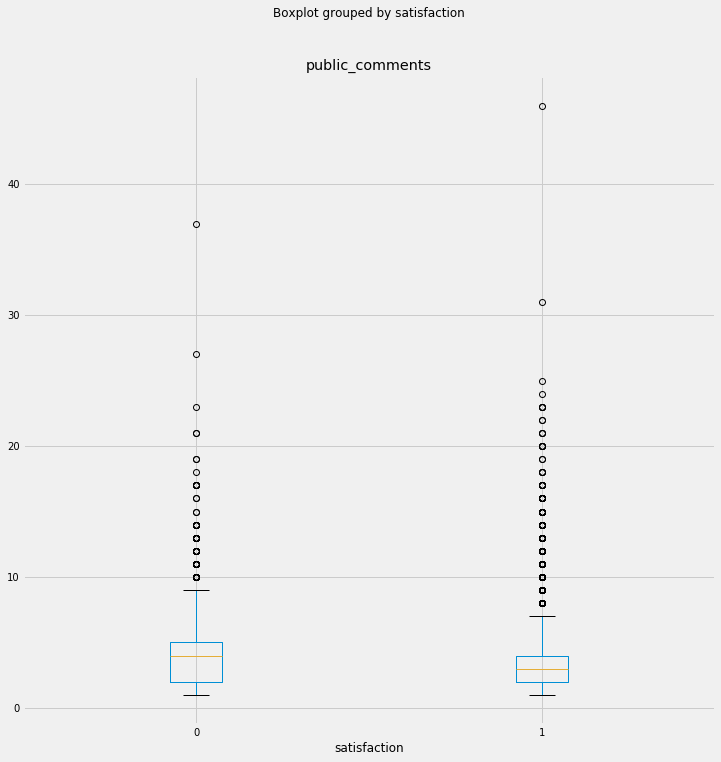

In [32]:
#look at boxplot of fpublic_comments
df.boxplot(column=['public_comments'],by='satisfaction')

# Test/Train Split

In [33]:
# divide the data using our train, test, split

from sklearn.model_selection import train_test_split

X = df.drop(columns=['satisfaction','created_date','solved_date'])
y = df['satisfaction'].astype(np.int)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 24)

In [34]:
# check for class inbalance after splitting the data
print (y_train.value_counts())

1    16823
0     1377
Name: satisfaction, dtype: int64


In [35]:
#!pip install imbalanced-learn

In [36]:
#Use SMOTE to deal with inbalanced classes

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
print (np.bincount(y_train_res))
print (X_train_res.shape)

Using TensorFlow backend.


[16823 16823]
(33646, 23)


In [37]:
type(X_train_res)

numpy.ndarray

# Decision Tree to look for feature importance

let's do a tree model before we scale the data.

In [46]:
# Instantiate a DecisionTreeClassifier (with random_state=1). Let's just start with a depth of 3, we will re-evaluate later.
from sklearn.tree import DecisionTreeClassifier

feature_cols = X.columns
treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

In [47]:
treeclf.fit(X_train_res,y_train_res)
treeclf.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.02101121,
       0.11433207, 0.67075096, 0.        , 0.        , 0.17333676,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.020569  ,
       0.        , 0.        , 0.        ])

In [48]:
# "Gini importance" of each feature: the (normalized) total reduction of error brought by that feature.
pd.DataFrame({'feature':feature_cols, 'importance':treeclf.feature_importances_})

,feature,importance
0,hour_ticket_created,0.000000
1,agent_wait_time,0.000000
2,assign_time,0.000000
3,first_reply_time,0.000000
4,first_resolution_time,0.021011
5,full_resolution_time,0.114332
6,private_comments,0.670751
7,public_comments,0.000000
8,agent_stations,0.000000
9,reopens,0.173337


In [49]:
y_pred = treeclf.predict(X_test)

In [50]:
# Let's figure out how deep our tree should go using AUC since it is a classification problem

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

roc_auc

0.8029546531658429

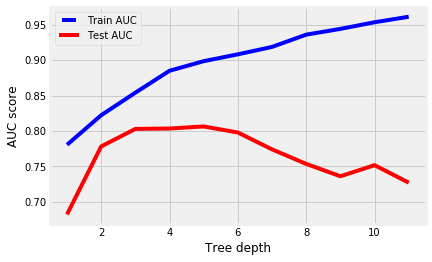

In [51]:
max_depth_range = list(range(1, 12))

train_results = []
test_results = []

for max_depth in max_depth_range:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(X_train_res, y_train_res)
    train_pred = dt.predict(X_train_res)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_res, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depth_range, train_results, color='blue', label='Train AUC')
line2, = plt.plot(max_depth_range, test_results, color='red', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

Max depth 3 and 5 had almost identical results. So we might as well stick with a tree of 3 to keep it simple.

In [52]:
# Create a Graphviz file.
from sklearn.tree import export_graphviz
export_graphviz(treeclf, out_file='csat.dot', feature_names=feature_cols)

In [53]:
#conda install python-graphviz

/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


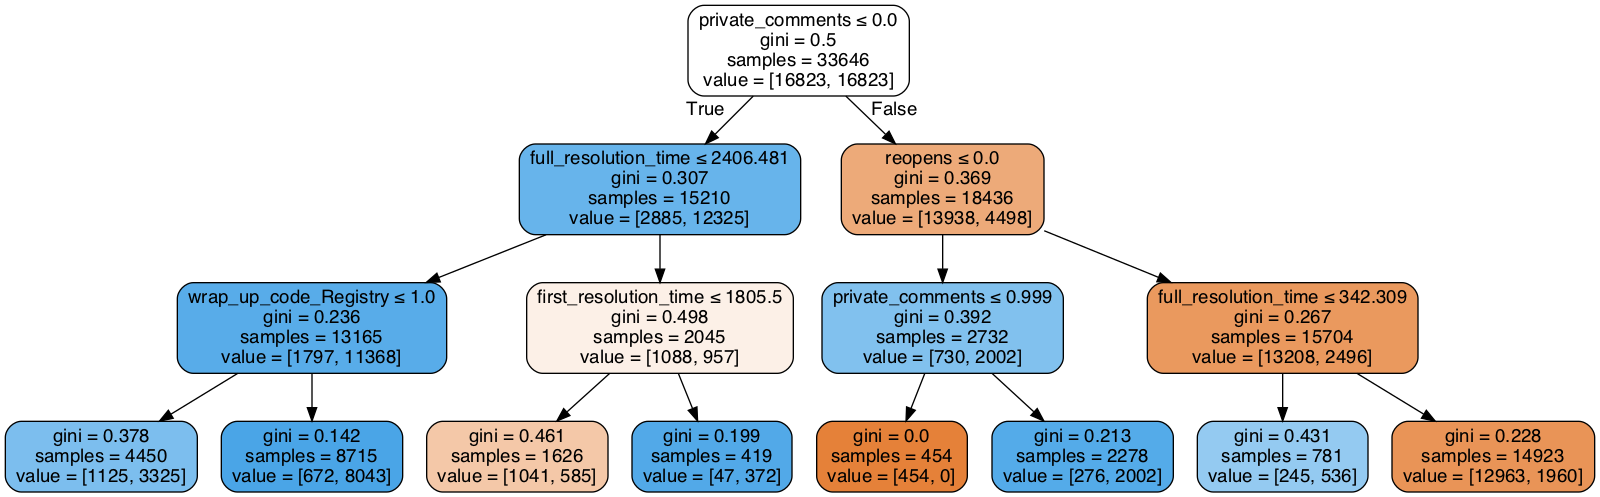

In [54]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(treeclf, out_file=dot_data, feature_names=feature_cols, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Summary:
In looking at the data, the 5 most important features are:

1. full resolution time
2. first resolution time
3. reopens
4. wrap up code is registry
5. the number of private comments

# Other Models 

For remaining models, we need to scale the data. 

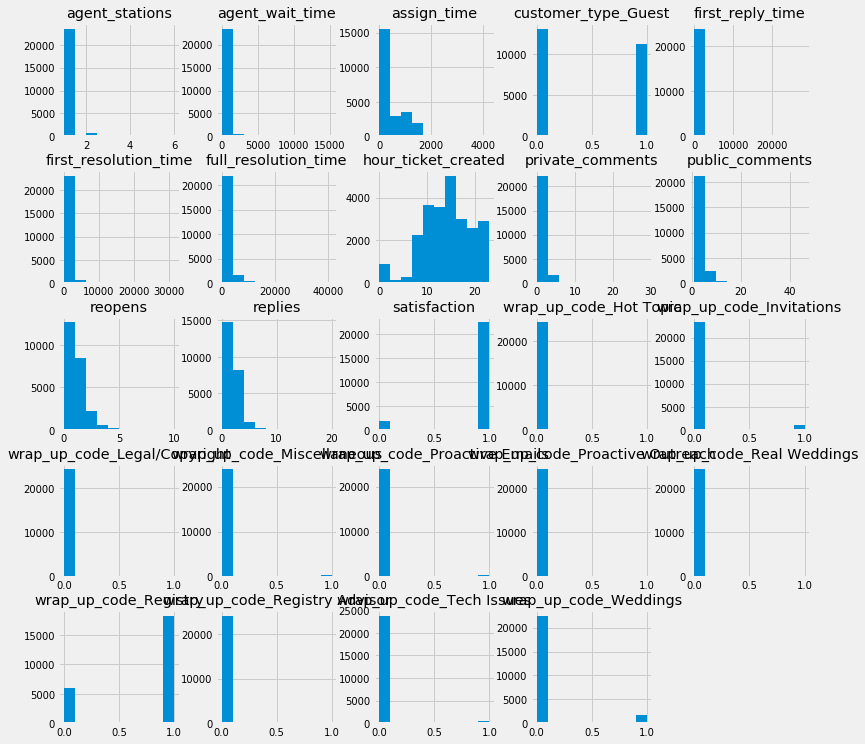

In [38]:
df.hist();

In [39]:
#scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Feature Selection

- Let's use feature selection for k = 5 to see if the features we get match up to what our decision tree said

In [40]:
from sklearn.feature_selection import SelectKBest

select = SelectKBest(k=5)
select.fit(X_train_scaled, y_train_res)

#transform training
X_train_selected = select.transform(X_train_scaled)

mask = select.get_support()

print(mask)

[False False False False False  True  True  True False  True  True False
 False False False False False False False False False False False]


Text(0.5, 0, 'Sample index')

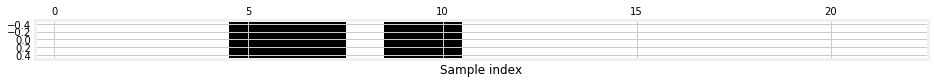

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
#black is true 
plt.matshow(mask.reshape(1, -1), cmap = 'gray_r')
plt.xlabel('Sample index')

In [42]:
cols = []
for col, val in zip(X.columns, select.get_support()):
    if val == True:
        cols.append(col)

cols

['full_resolution_time',
 'private_comments',
 'public_comments',
 'reopens',
 'replies']

### Summary:
In looking at the results, the 5 most important features are:

1. full resolution time
2. the number of private comments
3. the number of public comments
4. the number of reopens
5. the number of replies

The number of replies = number of private comments + number of public comments, so re-run for the top 7 features and see if that matches better with the results from the decision tree.

In [43]:
from sklearn.feature_selection import SelectKBest

select = SelectKBest(k=7)
select.fit(X_train_scaled, y_train_res)

#transform training
X_train_selected = select.transform(X_train_scaled)

mask = select.get_support()

print(mask)

[False  True False False False  True  True  True False  True  True False
 False False False False False False False  True False False False]


In [44]:
cols = []
for col, val in zip(X.columns, select.get_support()):
    if val == True:
        cols.append(col)

cols

['agent_wait_time',
 'full_resolution_time',
 'private_comments',
 'public_comments',
 'reopens',
 'replies',
 'wrap_up_code_Registry']

From the 2 lists, consolidate important features to:

1. agent wait time
2. full resolution time
3. first resolution time
4. reopens
5. wrap up code is registry
6. the number of private comments
7. the number of public comments

In [55]:
feature_cols

Index(['hour_ticket_created', 'agent_wait_time', 'assign_time',
       'first_reply_time', 'first_resolution_time', 'full_resolution_time',
       'private_comments', 'public_comments', 'agent_stations', 'reopens',
       'replies', 'customer_type_Guest', 'wrap_up_code_Hot Topic',
       'wrap_up_code_Invitations', 'wrap_up_code_Legal/Copyright',
       'wrap_up_code_Miscellaneous', 'wrap_up_code_Proactive Emails',
       'wrap_up_code_Proactive Outreach', 'wrap_up_code_Real Weddings',
       'wrap_up_code_Registry', 'wrap_up_code_Registry Advisor',
       'wrap_up_code_Tech Issues', 'wrap_up_code_Weddings'],
      dtype='object')

In [56]:
X_test_scaled_select = X_test_scaled[:,[1,4,5,6,7,9,19]]
X_train_scaled_select = X_train_scaled[:,[1,4,5,6,7,9,19]]

In [57]:
X_train_scaled_select.shape

(33646, 7)

In [58]:
X_test_scaled_select.shape

(6067, 7)

# Logistic regressor

- Let's look at the results from a logistic regressor and see how it does with classification, start with all the features.

In [59]:
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [64]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train_scaled,y_train_res)
pred_lr = lr.predict(X_test_scaled)

print(lr.score(X_train_scaled,y_train_res))
print(classification_report(pred_lr, y_test))

0.8414967603875646
              precision    recall  f1-score   support

           0       0.78      0.39      0.52       950
           1       0.90      0.98      0.94      5117

    accuracy                           0.89      6067
   macro avg       0.84      0.68      0.73      6067
weighted avg       0.88      0.89      0.87      6067



In [65]:
pipe = make_pipeline(PolynomialFeatures(), LogisticRegression())

params = {'polynomialfeatures__degree': [i for i in range(1, 5)],
         'logisticregression__C': [0.1, 1, 5, 10, 100]}

grid = GridSearchCV(pipe, param_grid=params, cv = 5)

In [ ]:
grid_results = grid.fit(X_train_scaled,y_train_res)

In [ ]:
grid_results.best_estimator_

In [ ]:
pred_lr = best.grid_results(X_test_scaled)

In [63]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(pred_lr, y_test))

              precision    recall  f1-score   support

           0       0.78      0.39      0.52       950
           1       0.90      0.98      0.94      5117

    accuracy                           0.89      6067
   macro avg       0.84      0.68      0.73      6067
weighted avg       0.88      0.89      0.87      6067



### Redo the analysis using only the select features

In [74]:
lr_sel = LogisticRegression()
lr_sel.fit(X_train_scaled_select,y_train_res)
pred_lr_sel = lr_sel.predict(X_test_scaled_select)

print(lr_sel.score(X_train_scaled_select,y_train_res))

print(classification_report(pred_lr_sel, y_test))

0.822326576710456
              precision    recall  f1-score   support

           0       0.75      0.33      0.46      1071
           1       0.87      0.98      0.92      4996

    accuracy                           0.86      6067
   macro avg       0.81      0.65      0.69      6067
weighted avg       0.85      0.86      0.84      6067



In [ ]:
pipe = make_pipeline(PolynomialFeatures(), LogisticRegression())

params = {'polynomialfeatures__degree': [i for i in range(1, 5)],
         'logisticregression__C': [0.1, 1, 5, 10, 100]}

grid = GridSearchCV(pipe, param_grid=params, cv = 5)

In [ ]:
grid.fit(X_train_scaled_select,y_train_res)

In [ ]:
grid.best_estimator_

In [ ]:
grid.best_score_

In [ ]:
best2 = grid.best_estimator_

best2.fit(X_train_scaled_select,y_train_res)

pred_lr_sel = best.predict(X_test_scaled_select)
print(classification_report(pred_lr_sel, y_test))

The best model is a degree of 1 with a c of 10 in both cases.

@Jacob - I re-ran all the cells to get a clean output for submitting my final project and my grid searches just won't execute. After about 30 minutes my computer just crashes. No idea why. But the best model was a degree of 1 regardless. 

# KNN classification


In [62]:
#knn analysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [63]:
params = {'n_neighbors': [i for i in range(2, 14)], 'metric':['minkowski','manhattan','euclidean']}

grid = GridSearchCV(KNeighborsClassifier(), param_grid=params)

In [64]:
grid.fit(X_train_scaled, y_train_res)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'metric': ['minkowski', 'manhattan', 'euclidean'],
                         'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [65]:
grid.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [66]:
grid.best_score_

0.9500386375795042

The best KNeighbors Classifer was 3 neighbors using the "manhattan" metric

## KNN Classification with selected features

In [67]:
#repeat with selected features
gridv2 = GridSearchCV(KNeighborsClassifier(), param_grid=params)

gridv2.fit(X_train_scaled_select, y_train_res)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'metric': ['minkowski', 'manhattan', 'euclidean'],
                         'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [68]:
gridv2.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [69]:
gridv2.best_score_

0.9349105391428402

Best model is n_neighbors = 3 and metric= manhattan for both versions. Very little difference in score with using all features vs. the main 7 features.